In [32]:
import os
import itertools
import traceback
import numpy as np
from PIL import Image
from tqdm import tqdm
from io import BytesIO
import pygraphviz as pgv
from IPython import display
from threading import Thread
from multiprocessing import Manager, Queue
from tqdm.contrib.concurrent import process_map
from typing import Tuple, List, Dict, Optional, BinaryIO
from custom_types import Vertex, CostFunction, Graph, Solution

In [33]:
def generate_random_graph(
  min_num_vertices: int = 10,
  max_num_vertices: int = 40,
  min_edge_cost: float = 0,
  max_edge_cost: float = 1,
) -> Graph:
  np.random.seed(int.from_bytes(os.urandom(4), byteorder='little'))
  num_vertices = np.random.randint(min_num_vertices, max_num_vertices+1)
  
  # Generate random distance matrix
  # NOTE: we'll only be using the values to the right of the diagonal
  distance_matrix = np.random.uniform(min_edge_cost, max_edge_cost, size=(num_vertices, num_vertices))

  # Create a fully connected graph from the distance matrix
  vertices: List[Vertex] = list(f"V{i}" for i in range(num_vertices))
  cost_function: CostFunction = {}
  for v in vertices:
    cost_function[v] = {v: 0}

  for i, u in enumerate(vertices):
    for j in range(i+1, len(vertices)):
      v = vertices[j]
      cost_function[u][v] = cost_function[v][u] = distance_matrix[i][j]
  
  return (vertices, cost_function)

In [34]:
def are_adjacent(u: Vertex, v: Vertex, solution: Solution) -> bool:
  assert u in solution
  assert v in solution
  u_idx = solution.index(u)
  return solution[(u_idx+1)%len(solution)] == v or solution[(u_idx-1+len(solution))%len(solution)] == v

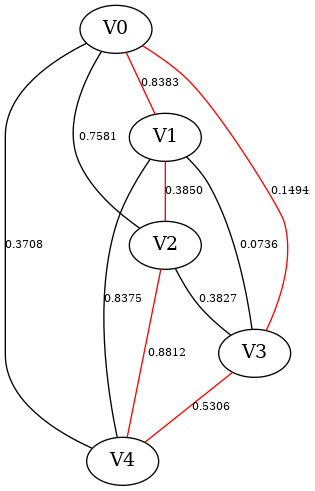

In [35]:
def draw_graph(graph: Graph, highlight: Optional[Solution] = None) -> Image.Image:
  vertices, cost_function = graph
  viz = pgv.AGraph()
  viz.add_nodes_from(vertices)
  for i, u in enumerate(vertices):
    for v in vertices[i+1:]:
      cost = cost_function[u][v]
      color="red" if highlight is not None and are_adjacent(u, v, highlight) else "black"
      viz.add_edge(u, v, label=f"{cost:.4f}", color=color)
  viz.layout(prog="dot", args="-Efontsize=8 -Elabeldist=20")
  stream = BytesIO(viz.draw(format="png"))
  return Image.open(stream)

if __name__ == "__main__":
  graph = generate_random_graph(min_num_vertices=5, max_num_vertices=5)
  display.display(draw_graph(graph, highlight=["V0", "V1", "V2", "V4", "V3"]))

In [36]:
def serialize_graphs(fp: BinaryIO, *graphs: List[Graph]) -> BinaryIO:
  for i, graph in enumerate(graphs):
    vertices, cost_function = graph
    if i > 0:
      fp.write(b"\n")
    parts = [len(vertices),*vertices]
    for u_i, u in enumerate(vertices):
      for v in vertices[u_i+1:]:
        parts.append(cost_function[u][v])
    fp.write(b",".join(str(x).encode("utf-8") for x in parts))
  return fp

def deserialize_graphs(fp: BinaryIO) -> Tuple[List[Graph], List[int]]:
  graphs: List[Graph] = []
  graph_end_positions: List[int] = []
  try:
    while len(line := fp.readline().decode("utf-8")) > 0:
      parts = line.split(",")
      n = int(parts[0])
      vertices: List[Vertex] = parts[1:n+1]
      cost_function: CostFunction = {}
      for v in vertices:
        cost_function[v] = {v: 0}
      u_idx = 0
      v_idx = 1
      assert len(parts) == n + 1 + n*(n-1)/2
      for i in range(n+1, len(parts)):
        u = vertices[u_idx]
        v = vertices[v_idx]
        c = float(parts[i])
        cost_function[u][v] = cost_function[v][u] = c
        v_idx += 1
        if v_idx == n:
          u_idx += 1
          v_idx = u_idx + 1
      graphs.append((vertices, cost_function))
      graph_end_positions.append(fp.tell()-1)
  except Exception:
    traceback.print_exc()
    print(f"Managed to successfully recover {len(graphs)} graphs")
  return graphs, graph_end_positions

if __name__ == "__main__":
  graph = generate_random_graph(min_num_vertices=3, max_num_vertices=3)
  print(graph)
  print("")
  with BytesIO() as fp:
    serial = serialize_graphs(fp, graph)
    fp.seek(0)
    print(fp.read())
    print("")
    fp.seek(0)
    reconstructed = deserialize_graphs(fp)[0][0]
  print(reconstructed)
  assert graph == reconstructed

(['V0', 'V1', 'V2'], {'V0': {'V0': 0, 'V1': 0.10258265517267318, 'V2': 0.8856801065284579}, 'V1': {'V1': 0, 'V0': 0.10258265517267318, 'V2': 0.4336763120337358}, 'V2': {'V2': 0, 'V0': 0.8856801065284579, 'V1': 0.4336763120337358}})

b'3,V0,V1,V2,0.10258265517267318,0.8856801065284579,0.4336763120337358'

(['V0', 'V1', 'V2'], {'V0': {'V0': 0, 'V1': 0.10258265517267318, 'V2': 0.8856801065284579}, 'V1': {'V1': 0, 'V0': 0.10258265517267318, 'V2': 0.4336763120337358}, 'V2': {'V2': 0, 'V0': 0.8856801065284579, 'V1': 0.4336763120337358}})


In [37]:
if __name__ == "__main__":
  num_graphs_to_generate = 10000

  sample_graphs_path = "sample_graphs.dat"
  sample_graphs: List[Graph] = []
  if os.path.exists(sample_graphs_path):
    with open(sample_graphs_path, "r+b") as fp:
      sample_graphs, graph_end_positions = deserialize_graphs(fp)
      fp.seek(graph_end_positions[-1])
      fp.truncate()
    
    print(f"Loaded {len(sample_graphs)}/{num_graphs_to_generate} ({100*(len(sample_graphs)/num_graphs_to_generate):.2f})% sample graphs")
  
  if len(sample_graphs) < num_graphs_to_generate:
    def make_graph(q: "Queue[Tuple[str, Optional[Graph]]]"):
      graph = generate_random_graph(max_num_vertices=30)
      q.put(("SERIALIZE", graph))
      return graph
    
    def listener(q: "Queue[Tuple[str, Optional[Graph]]]", graphs: List[Graph]):
      while True:
        cmd, arg = q.get()
        if cmd == "STOP":
          break
        elif cmd == "SERIALIZE":
          graphs.append(arg)
          with open(sample_graphs_path, "wb" if len(graph) == 1 else "ab") as fp:
            if len(graphs) > 1:
              fp.write(b"\n")
            serialize_graphs(fp, arg)
        else:
          raise AssertionError(f"Unknown command: {cmd}")
    
    manager = Manager()
    q: "Queue[Tuple[str, Optional[Graph]]]" = manager.Queue()
    l = Thread(target=listener, args=(q, sample_graphs), daemon=True)
    l.start()
    process_map(make_graph, [q]*(num_graphs_to_generate-len(sample_graphs)), max_workers=5, tqdm_class=tqdm, chunksize=1000)
    q.put(("STOP", None))
    l.join()
    print(f"Got {len(sample_graphs)}/{num_graphs_to_generate} ({100*(len(sample_graphs)/num_graphs_to_generate):.2f})% sample graphs")

  assert len(np.unique(np.array(list(str(g) for g in sample_graphs)))) == num_graphs_to_generate, "Set contains duplicates"

100%|██████████| 10000/10000 [00:05<00:00, 1700.80it/s]


Got 10000/10000 (100.00)% sample graphs
